# Tensorflow

In [ ]:
!pip install -q tensorflow-gpu==2.0.0-rc1
import tensorflow as tf

     |████████████████████████████████| 380.5MB 43kB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 501kB 49.6MB/s 
     |████████████████████████████████| 4.3MB 47.5MB/s 


# 9주차 데이터 학습 모델 설계

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# import 
import os
import pandas as pd 
import glob

In [ ]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/') # DataPath 설정 
current_path = os.getcwd() # 현재 폴더 위치 
train_path = current_path+ '/capstone_data/train' # 데이터 패스 설정 
print(train_path)

/content/gdrive/My Drive/Colab Notebooks/capstone_data/train


In [ ]:
df = pd.read_json('./capstone_data/data_version_2.json')

In [ ]:
df

,tags,id,plylst_title,songs,like_cnt,updt_date,len,tag_len,songs2,song2_len
1,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,28,2,"[83116, 276692, 166267, 354465, 256598, 666852...",25
2,"[운동, 드라이브, Pop, 트로피컬하우스, 힐링, 기분전환, 2017, 팝, 트렌...",69252,2017 Pop Trend,"[418694, 222305, 96545, 135950, 304687, 457451...",435,2017-09-15 15:59:26.000,30,10,"[418694, 222305, 96545, 135950, 304687, 457451...",22
3,"[잔잔한, 추억, 회상]",36557,멍청이.. 내맘도 몰라.,"[496913, 632529, 501426, 515574, 411161, 10341...",5,2008-09-23 22:32:02.000,20,3,"[632529, 501426, 515574, 411161, 103411, 17813...",17
5,"[우울, 힐링, 힘내]",112060,지친 너를 위로해줄 제목편지 준비해봤어,"[449808, 691770, 640657, 313395, 697100, 34090...",1,2018-01-04 22:49:29.000,21,3,"[691770, 640657, 313395, 697100, 340905, 22169...",15
6,[비오는날],75342,"이렇게 비 내리는 날이면, 너도 내 생각 할까..","[379674, 164522, 33196, 281228, 640012, 117969...",17,2016-10-12 16:22:17.000,18,1,"[164522, 33196, 640012, 117969, 75425, 627363,...",15
...,...,...,...,...,...,...,...,...,...,...
45430,"[겨울, 설렘, 사랑]",133185,첫눈처럼 설레였던 그날♥,"[334564, 221618, 504089, 321512, 476845, 11368...",154,2014-12-24 14:25:23.000,25,3,"[334564, 221618, 476845, 113687, 211159, 51275...",21
45434,[팝],33486,들을수록 걸크러쉬 물씬 느껴지는 음악리스트,"[619719, 374517, 323561, 79157, 170970, 241952...",4,2017-03-18 00:07:08.000,29,1,"[619719, 374517, 323561, 79157, 241952, 587512...",17
45435,[인디],153220,오후의 어쿠스틱 vol.2,"[627005, 253230, 643932, 22659, 316149, 247137...",39,2013-04-19 01:36:45.000,21,1,"[627005, 253230, 643932, 22659, 316149, 247137...",20
45436,[여친],79538,여자친구 명곡,"[65053, 389127, 443914, 498028, 375431, 312296...",6,2018-03-09 14:24:37.000,23,1,"[65053, 389127, 443914, 498028, 375431, 312296...",23


In [ ]:
df.shape

(29354, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29354 entries, 1 to 45437
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tags          29354 non-null  object
 1   id            29354 non-null  int64 
 2   plylst_title  29354 non-null  object
 3   songs         29354 non-null  object
 4   like_cnt      29354 non-null  int64 
 5   updt_date     29354 non-null  object
 6   len           29354 non-null  int64 
 7   tag_len       29354 non-null  int64 
 8   songs2        29354 non-null  object
 9   song2_len     29354 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 2.5+ MB


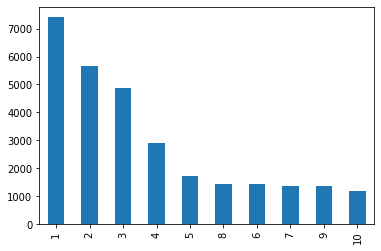

In [ ]:
df.tags.map(lambda x: len(x)).value_counts().plot.bar()

In [ ]:
df['songs2'].unique

<bound method Series.unique of 1        [83116, 276692, 166267, 354465, 256598, 666852...
2        [418694, 222305, 96545, 135950, 304687, 457451...
3        [632529, 501426, 515574, 411161, 103411, 17813...
5        [691770, 640657, 313395, 697100, 340905, 22169...
6        [164522, 33196, 640012, 117969, 75425, 627363,...
                               ...                        
45430    [334564, 221618, 476845, 113687, 211159, 51275...
45434    [619719, 374517, 323561, 79157, 241952, 587512...
45435    [627005, 253230, 643932, 22659, 316149, 247137...
45436    [65053, 389127, 443914, 498028, 375431, 312296...
45437    [287003, 408232, 625933, 543298, 222713, 10445...
Name: songs2, Length: 29354, dtype: object>

In [ ]:
# 태그 개수 세기

tag_cnt=set()
for i in df['tags']:
    for j in i:
        tag_cnt.add(j)

In [ ]:
type(tag_cnt)

set

In [ ]:
tag_cnt # 전체 태그

In [ ]:
len(tag_cnt) # 전체 태그 개수

1382

In [ ]:
# 음원 개수 세기

song_cnt=set()
for i in df['songs2']:
    for j in i:
        song_cnt.add(j)

In [ ]:
song_cnt

In [ ]:
len(song_cnt)

69888

# SVD CF 다시 3

In [ ]:
import os
import pandas as pd 
import glob
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
# pivot table 불러오기
df_pivot = pd.read_pickle('./capstone_data/pivot_songs_tags.pickle')

In [ ]:
df_pivot.index.name = 'tags'
df_pivot.columns.name = 'songs'
df_pivot.head()

songs,262145,393217,393222,10,524300,393232,524305,262164,262170,655386,262171,28,262174,30,32,655402,524331,393260,131117,262189,47,262192,655409,393266,131119,524340,54,655414,393273,262202,131131,393276,393277,62,262206,393280,524349,655426,67,524356,...,393139,524213,130998,524215,130997,131001,524217,262074,655292,524221,262081,524229,393158,131015,655305,524234,131019,393164,655308,262094,655309,262090,524245,655317,131030,393177,524251,393184,262114,262119,524265,131049,262125,262126,131057,262130,262138,262140,262142,131071
tags,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
침대,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
로우파이,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
해외힙합,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
눈,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
감성적,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_song_meta = pd.read_json('./capstone_data/song_meta.json')

In [ ]:
df_song_meta.head()

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2
3,"[GN1102, GN1101]",20151016,Feeling Right (Everything Is Nice) (Feat. Popc...,2644882,[838543],Feeling Right (Everything Is Nice) (Feat. Popc...,[GN1100],[Matoma],3
4,"[GN1802, GN1801]",20110824,그남자 그여자,2008470,[560160],그남자 그여자,[GN1800],[Jude Law],4


In [ ]:
tag_name_erase = "로우파이"

In [ ]:
df_pivot.index.tolist().index(tag_name_erase)

1

In [ ]:
# matrix는 pivot_table 값을 numpy matrix로 만든 것 
%time matrix = df_pivot.values

CPU times: user 72 µs, sys: 0 ns, total: 72 µs
Wall time: 76.5 µs


In [ ]:
# tag_ratings_mean은 tag의 평균 song 개수 
%time tag_ratings_mean = np.mean(matrix, axis = 1)

CPU times: user 213 ms, sys: 0 ns, total: 213 ms
Wall time: 218 ms


In [ ]:
# R_user_mean : 사용자-영화에 대해 사용자 평균 평점을 뺀 것.
%time matrix_tag_mean = matrix - tag_ratings_mean.reshape(-1, 1)

CPU times: user 343 ms, sys: 0 ns, total: 343 ms
Wall time: 344 ms


In [ ]:
matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
matrix.shape

(1382, 69888)

In [ ]:
tag_ratings_mean.shape

(1382,)

In [ ]:
matrix_tag_mean.shape

(1382, 69888)

In [ ]:
pd.DataFrame(matrix_tag_mean, columns=df_pivot.columns).head()

songs,262145,393217,393222,10,524300,393232,524305,262164,262170,655386,262171,28,262174,30,32,655402,524331,393260,131117,262189,47,262192,655409,393266,131119,524340,54,655414,393273,262202,131131,393276,393277,62,262206,393280,524349,655426,67,524356,...,393139,524213,130998,524215,130997,131001,524217,262074,655292,524221,262081,524229,393158,131015,655305,524234,131019,393164,655308,262094,655309,262090,524245,655317,131030,393177,524251,393184,262114,262119,524265,131049,262125,262126,131057,262130,262138,262140,262142,131071
0,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,...,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,0.984962,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038,-0.015038
1,-0.002461,-0.002461,-0.002461,0.997539,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,...,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461,-0.002461
2,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,...,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806,-0.003806
3,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,0.957661,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,3.957661,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,...,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,0.957661,-0.042339,-0.042339,0.957661,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339,-0.042339
4,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0.003277,-0

In [ ]:
# scipy에서 제공해주는 svd.  
# U 행렬, sigma 행렬, V 전치 행렬을 반환.

%time U, sigma, Vt = svds(matrix_tag_mean, k = 12)

CPU times: user 12.8 s, sys: 116 ms, total: 13 s
Wall time: 6.65 s


In [ ]:
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(1382, 12)
(12,)
(12, 69888)


현재 이 Sigma 행렬은 0이 아닌 값만 1차원 행렬로 표현된 상태

즉, 0이 포함된 대칭행렬로 변환할 때는 numpy의 diag를 이용해야 함

In [ ]:
%time sigma = np.diag(sigma)

CPU times: user 0 ns, sys: 660 µs, total: 660 µs
Wall time: 667 µs


In [ ]:
sigma.shape

(12, 12)

In [ ]:
sigma[2]

array([  0.       ,   0.       , 431.0575676,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ])

In [ ]:
# U, Sigma, Vt의 내적을 수행하면, 다시 원본 행렬로 복원이 된다. 
# 거기에 + 사용자 평균 rating을 적용한다. 
%time svd_tag_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + tag_ratings_mean.reshape(-1, 1)

CPU times: user 627 ms, sys: 294 ms, total: 921 ms
Wall time: 635 ms


In [ ]:
%time df_svd_preds = pd.DataFrame(svd_tag_predicted_ratings, columns = df_pivot.columns)
df_svd_preds.head()

CPU times: user 284 µs, sys: 0 ns, total: 284 µs
Wall time: 288 µs


songs,262145,393217,393222,10,524300,393232,524305,262164,262170,655386,262171,28,262174,30,32,655402,524331,393260,131117,262189,47,262192,655409,393266,131119,524340,54,655414,393273,262202,131131,393276,393277,62,262206,393280,524349,655426,67,524356,...,393139,524213,130998,524215,130997,131001,524217,262074,655292,524221,262081,524229,393158,131015,655305,524234,131019,393164,655308,262094,655309,262090,524245,655317,131030,393177,524251,393184,262114,262119,524265,131049,262125,262126,131057,262130,262138,262140,262142,131071
0,0.009627,-0.003137,0.055012,0.028587,0.029738,0.004280,0.004204,0.010074,0.012362,0.003476,0.002878,0.010296,0.003658,0.022544,0.015373,0.002603,0.005208,0.013804,0.053384,0.033662,0.003658,-0.003414,0.003323,0.015592,0.024807,0.022042,0.007276,0.010515,0.003306,-0.020085,0.004007,0.010177,-0.002783,0.033398,0.006380,0.000805,0.003845,-0.003347,0.019609,0.101648,...,0.005626,-0.012169,0.017445,0.001413,0.010570,-0.036531,0.011432,0.004455,0.024303,-0.005754,-0.005397,-0.003541,0.009260,0.049861,0.007447,0.002857,0.017139,0.001518,0.014334,0.005576,0.002213,0.004846,-0.010040,0.011751,0.001208,-0.002708,0.013452,0.004667,0.014959,0.004271,-0.001773,0.003062,0.003470,0.009870,0.005038,0.009196,0.001538,0.011078,-0.001777,0.010460
1,0.004792,0.001572,0.001774,0.004668,0.001286,0.002210,0.002268,0.002525,0.000934,0.002170,0.002551,0.004296,0.001957,0.008329,0.003034,0.002977,0.003171,0.010332,0.005904,0.007461,0.003890,0.000342,0.003844,0.004173,0.002351,0.008369,0.000136,0.004519,0.001507,-0.010399,0.003396,0.005248,-0.002497,0.000880,0.002732,0.002043,0.002052,0.000308,0.001474,-0.003513,...,0.002771,-0.003721,0.003461,0.001897,0.000954,-0.008466,0.003806,0.002678,0.005616,0.001689,-0.001453,0.000666,0.002027,0.007126,0.002243,0.001492,0.001645,0.001639,0.002997,0.004592,0.002428,0.001891,0.000102,-0.000343,0.001669,-0.000188,0.003660,0.001663,0.003351,-0.000482,0.002444,0.001799,0.002170,0.004248,0.000457,0.002500,0.001429,0.002717,0.001612,0.002906
2,0.041468,0.006025,0.000979,-0.000185,0.000113,-0.000584,-0.001301,0.002064,0.006898,-0.000452,0.003383,-0.000500,-0.000279,0.026816,0.000063,0.013138,-0.002104,0.007929,0.028563,0.006753,0.009353,-0.000730,-0.002415,-0.003341,0.000609,0.103181,-0.002751,0.012737,-0.001593,-0.006495,0.014361,-0.003431,-0.004600,0.010785,-0.002245,0.006107,-0.000415,0.000069,-0.000089,-0.007940,...,-0.001501,0.000702,0.015631,-0.001208,-0.002985,0.002088,-0.000643,-0.001286,0.016248,-0.002960,0.007363,-0.001365,-0.000500,-0.001094,-0.001979,-0.001050,0.000406,-0.000570,0.000654,-0.002445,0.002131,-0.000550,-0.000860,-0.000832,-0.000357,-0.003322,0.001470,0.000643,-0.000149,0.020426,0.013245,-0.000471,-0.000450,-0.001288,-0.001100,-0.000304,0.000740,-0.000970,0.005458,0.003071
3,0.012526,-0.007294,-0.049152,0.016791,0.007652,0.008474,-0.000561,0.216952,-0.007989,-0.000448,-0.010792,0.018214,-0.015798,-0.019342,-0.019923,-0.000327,-0.018256,0.093414,-0.005454,0.057494,0.006188,-0.016744,-0.052922,-0.056000,-0.012182,0.029848,0.066373,0.022706,-0.009206,5.136776,-0.006904,0.053609,0.125857,0.087784,-0.010716,-0.000943,0.068117,0.006889,0.075727,0.059781,...,0.107686,0.001396,-0.004747,0.007985,0.009224,-0.050409,-0.007999,-0.007204,-0.029613,-0.025877,0.139842,-0.009576,0.194051,0.010774,0.051396,0.150119,-0.004026,-0.019015,-0.003711,0.366904,-0.025602,0.012382,0.056145,0.112055,-0.001039,0.042679,-0.019832,-0.005309,0.020243,0.017145,-0.018081,0.272350,-0.000349,-0.086364,0.098438,-0.016312,0.005481,-0.000619,-0.011822,-0.029171
4,0.011637,0.001626,0.005995,0.003591,0.000791,0.000307,0.001230,0.000140,0.003197,0.000181,0.000660,0.000032,-0.000067,0.005010,0.004412,0.002946,0.000415,0.001938,0.007347,0.003517,0.001499,0.000029,0.000205,0.002677,0.001818,0.025723,0.002496,0.003864,0.001086,0.007377,0.003004,0.001935,0.001060,0.016859,-0.000036,0.001137,0.000311,-0.000326,0.009025,0.010817,...,0.000379,-0.001280,0.001176,-0.000350,0.002699,-0.003741,0.001855,0.000277,0.0074

In [ ]:
df_svd_preds.shape

(1382, 69888)

In [ ]:
#creating function to get recommendations, 코드 원상태
def svd_recommender(df_svd_preds, tag, ori_pivot, number_recomm):
    tag_row_number = df_pivot.index.tolist().index(tag)
    tag_predicted_songs = df_svd_preds.loc[tag_row_number, :].sort_values(ascending = False)
    recommend_song = tag_predicted_songs.head(number_recomm)
    top_song_names = df_song_meta[df_song_meta.id.isin(recommend_song.index)][['artist_name_basket','song_name']].values
    return recommend_song, top_song_names

In [ ]:
%time tag_song_recommendation = svd_recommender(df_svd_preds, '성탄절' , df_pivot, 10)

CPU times: user 20 ms, sys: 732 µs, total: 20.7 ms
Wall time: 22.5 ms


In [ ]:
df_song_meta[df_song_meta.id == 695032]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
695032,[GN0101],20121206,Jelly Christmas 2012 HEART PROJECT,2168409,"[3305, 1191, 205858, 436700, 672560]",크리스마스니까,[GN0100],"[성시경, 박효신, 이석훈, 서인국, VIXX (빅스)]",695032


In [ ]:
a,b=tag_song_recommendation

In [ ]:
a.index

Int64Index([326204, 695032, 387859, 358186, 112399, 468494, 422176, 5049,
            55791, 61771],
           dtype='int64', name='songs')

In [ ]:
b

array([[list(['성시경', '박효신', '서인국', 'VIXX (빅스)', '여동생']), '겨울 고백'],
       [list(['EXO']), '12월의 기적 (Miracles In December)'],
       [list(['Sia']), 'Snowman'],
       [list(['SG 워너비', '브라운아이드걸스']), 'Must Have Love'],
       [list(['아이유']), '미리 메리 크리스마스 (Feat. 천둥 Of MBLAQ)'],
       [list(['Ariana Grande']), 'Santa Tell Me'],
       [list(['Mariah Carey']), 'All I Want For Christmas Is You'],
       [list(['소녀시대-태티서 (Girls` Generation-TTS)']), 'Dear Santa'],
       [list(['EXO']), '첫 눈'],
       [list(['성시경', '박효신', '이석훈', '서인국', 'VIXX (빅스)']), '크리스마스니까']],
      dtype=object)

# For React js

In [ ]:
import json

In [ ]:
# pivot table 불러오기
df_pivot = pd.read_pickle('./capstone_data/pivot_songs_tags.pickle')

In [ ]:
unique_tags = list(set([tag for tags in df.tags for tag in tags]))

In [ ]:
len(unique_tags)

1382

In [ ]:
unique_tags[1382]

IndexError: ignored

In [ ]:
for i in range(1300,1376,5):
  print("{ title: '",unique_tags[i],"'}, ","{ title: '",unique_tags[i+1],"'}, ","{ title: '",unique_tags[i+2],"'}, ","{ title: '",unique_tags[i+3],"'}, ","{ title: '",unique_tags[i+4],"'}, " )

{ title: ' 출퇴근길 '},  { title: ' 스타일리쉬 '},  { title: ' 해외알앤비소울 '},  { title: ' 빅뱅 '},  { title: ' 수록곡 '}, 
{ title: ' 오디션 '},  { title: ' 새벽감성 '},  { title: ' 감성적인 '},  { title: ' 트로피칼 '},  { title: ' 힘내요 '}, 
{ title: ' 댄스 '},  { title: ' 성인가요 '},  { title: ' 장르불문 '},  { title: ' 그냥 '},  { title: ' 얼터너티브록 '}, 
{ title: ' 매장노래 '},  { title: ' bonOBono '},  { title: ' dance '},  { title: ' 빈지노 '},  { title: ' 어쿠스틱 '}, 
{ title: ' 신스팝 '},  { title: ' 힐링송 '},  { title: ' 끈적한 '},  { title: ' 이어폰 '},  { title: ' 로큰롤 '}, 
{ title: ' 여름향기 '},  { title: ' 미디어 '},  { title: ' 이디엠 '},  { title: ' 드림팝 '},  { title: ' 슬플때 '}, 
{ title: ' 시험기간 '},  { title: ' 뉴트로 '},  { title: ' 재즈피아노 '},  { title: ' 러브 '},  { title: ' 일렉트로닉 '}, 
{ title: ' 하드록 '},  { title: ' 이불 '},  { title: ' 여자 '},  { title: ' 오케스트라 '},  { title: ' 무기력 '}, 
{ title: ' 팝랩 '},  { title: ' 가을노래 '},  { title: ' 석양 '},  { title: ' 출근 '},  { title: ' 리믹스 '}, 
{ title: ' 일렉팝 '},  { title: ' 신나는노래 '},  { title: ' 여자보컬 '},  { title: ' 스윙